In [3]:
import pandas as pd

# Load data
file_path = "/content/2010-2024 (5%ers).csv"
df = pd.read_csv(file_path, delimiter="\t", header=0)

# Adjust column names
df.columns = ["Date", "Time", "Open", "High", "Low", "Close", "TickVol", "Vol", "Spread"]

# Convert Date and Time into a single datetime column
df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"])
df.drop(columns=["Date", "Time"], inplace=True)

# Set Datetime as index for filtering
df.set_index("Datetime", inplace=True)

# Extract Day
df["Day"] = df.index.date
unique_days = df["Day"].unique()

# Track counts
first_check_count = 0
london_breaks_asian = 0
newyork_breaks_london = 0
newyork_breaks_asian = 0
london_ny_combined_break = 0

second_check_count = 0
london_breaks_prev = 0
newyork_breaks_prev_without_london = 0
inside_range_close_london = 0  #  Count of daily close inside range after London breakout
inside_range_close_ny = 0      #  Count of daily close inside range after NY breakout

for i in range(1, len(unique_days)):  # Start from the second day
    prev_day = unique_days[i - 1]
    curr_day = unique_days[i]

    prev_day_data = df[df["Day"] == prev_day]
    curr_day_data = df[df["Day"] == curr_day]

    if prev_day_data.empty or curr_day_data.empty:
        continue

    # Calculate previous day's values
    prev_high = prev_day_data["High"].max()
    prev_low = prev_day_data["Low"].min()

    # Get Asian session high/low
    asian_data = curr_day_data.between_time("01:00", "09:00")
    if not asian_data.empty:
        asian_high = asian_data["High"].max()
        asian_low = asian_data["Low"].min()

        high_break = asian_high > prev_high
        low_break = asian_low < prev_low

        if high_break or low_break:
            first_check_count += 1  #  Asian broke previous day's high/low

            # **Now, only if Asian broke previous day's range, check London and NY**
            london_data = curr_day_data.between_time("10:00", "14:00")
            newyork_data = curr_day_data.between_time("15:00", "23:00")

            london_broke_asian = False
            ny_broke_london = False

            if not london_data.empty:
                london_high = london_data["High"].max()
                london_low = london_data["Low"].min()

                if high_break and london_high > asian_high:
                    london_breaks_asian += 1
                    london_broke_asian = True
                elif low_break and london_low < asian_low:
                    london_breaks_asian += 1
                    london_broke_asian = True

            if not newyork_data.empty:
                ny_high = newyork_data["High"].max()
                ny_low = newyork_data["Low"].min()

                if london_broke_asian and high_break and ny_high > london_high:
                    newyork_breaks_london += 1
                    ny_broke_london = True
                elif london_broke_asian and low_break and ny_low < london_low:
                    newyork_breaks_london += 1
                    ny_broke_london = True

                if high_break and ny_high > asian_high:
                    newyork_breaks_asian += 1
                elif low_break and ny_low < asian_low:
                    newyork_breaks_asian += 1

                if london_broke_asian and ny_broke_london:
                    london_ny_combined_break += 1

        else:
            # **Second Check: Asian does NOT break, but London/NY does**
            london_data = curr_day_data.between_time("10:00", "14:00")
            newyork_data = curr_day_data.between_time("15:00", "23:00")

            london_breaks = False
            ny_breaks = False

            # Check if London breaks the previous day's range (given Asian did not)
            if not london_data.empty:
                london_high = london_data["High"].max()
                london_low = london_data["Low"].min()

                if london_high > prev_high or london_low < prev_low:
                    london_breaks_prev += 1
                    london_breaks = True

                    # Check if daily close remains inside previous day's range
                    last_close = newyork_data["Close"].iloc[-1] if not newyork_data.empty else curr_day_data["Close"].iloc[-1]
                    if prev_low <= last_close <= prev_high:
                        inside_range_close_london += 1  #  Count for London breakout

            # Check if New York breaks the previous day's range (given London did NOT)
            if not newyork_data.empty and not london_breaks:
                ny_high = newyork_data["High"].max()
                ny_low = newyork_data["Low"].min()

                if ny_high > prev_high or ny_low < prev_low:
                    newyork_breaks_prev_without_london += 1
                    ny_breaks = True

                    # Check if daily close remains inside previous day's range
                    last_close = newyork_data["Close"].iloc[-1]
                    if prev_low <= last_close <= prev_high:
                        inside_range_close_ny += 1  #  Count for NY breakout

            # Second check is valid if either London or NY breaks it
            if london_breaks or ny_breaks:
                second_check_count += 1

# Print stats
print("\n===== First Check: Asian Breaks Previous Day's High/Low =====")
print(f"✅ Total times Asian broke previous day's high/low: {first_check_count}")
print(f"1. London breaks Asian's high/low (Given Asian broke prev day's high/low): {london_breaks_asian}")
print(f"2. New York breaks London's high/low (Given Asian broke prev day's high/low): {newyork_breaks_london}")
print(f"3. New York breaks Asian's high/low (Given Asian broke prev day's high/low): {newyork_breaks_asian}")
print(f"4. London breaks Asian & New York breaks London (Given Asian broke prev day's high/low): {london_ny_combined_break}")

print("\n===== Second Check: Asian Does NOT Break, but London or NY Does =====")
print(f"✅ Total times Asian DID NOT break previous day's high/low, but London or NY did: {second_check_count}")
print(f"5. London breaks previous day's high/low (Given Asian did NOT): {london_breaks_prev}")
print(f"6. New York breaks previous day's high/low (Given both Asian & London did NOT): {newyork_breaks_prev_without_london}")

print("\n===== Daily Close Inside Previous Day's Range =====")
print(f"✅ Days where daily close remains inside range after London breakout: {inside_range_close_london}")
print(f"✅ Days where daily close remains inside range after NY breakout (without London): {inside_range_close_ny}")



===== First Check: Asian Breaks Previous Day's High/Low =====
✅ Total times Asian broke previous day's high/low: 1816
1. London breaks Asian's high/low (Given Asian broke prev day's high/low): 897
2. New York breaks London's high/low (Given Asian broke prev day's high/low): 612
3. New York breaks Asian's high/low (Given Asian broke prev day's high/low): 1103
4. London breaks Asian & New York breaks London (Given Asian broke prev day's high/low): 612

===== Second Check: Asian Does NOT Break, but London or NY Does =====
✅ Total times Asian DID NOT break previous day's high/low, but London or NY did: 1414
5. London breaks previous day's high/low (Given Asian did NOT): 657
6. New York breaks previous day's high/low (Given both Asian & London did NOT): 757

===== Daily Close Inside Previous Day's Range =====
✅ Days where daily close remains inside range after London breakout: 265
✅ Days where daily close remains inside range after NY breakout (without London): 349


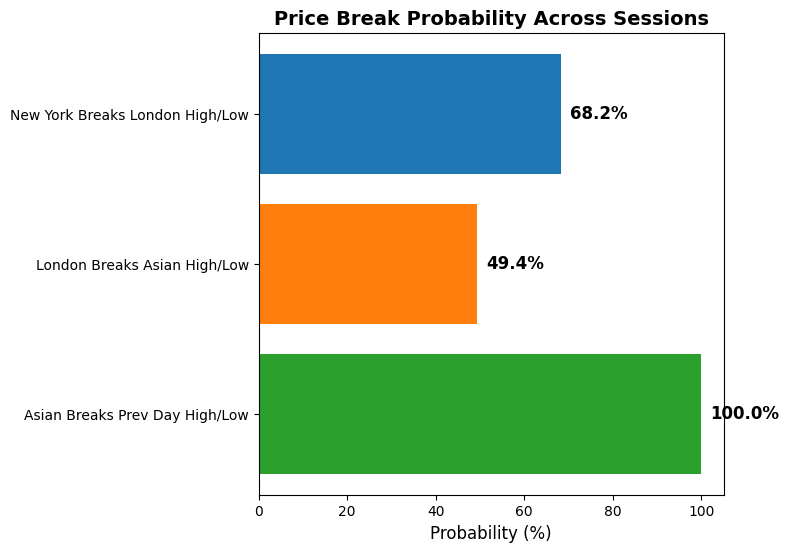

In [2]:
import matplotlib.pyplot as plt

# Data points
labels = ["Asian Breaks Prev Day High/Low", "London Breaks Asian High/Low", "New York Breaks London High/Low"]
values = [1816, 897, 612]

# Calculate percentages
percentages = [100, (897 / 1816) * 100, (612 / 897) * 100]

# Create the funnel chart
fig, ax = plt.subplots(figsize=(6, 6))
ax.barh(labels[::-1], percentages[::-1], color=["#1f77b4", "#ff7f0e", "#2ca02c"])

# Annotate the bars with actual numbers
for i, v in enumerate(percentages[::-1]):
    ax.text(v + 2, i, f"{v:.1f}%", va="center", fontsize=12, fontweight="bold")

ax.set_xlabel("Probability (%)", fontsize=12)
ax.set_title("Price Break Probability Across Sessions", fontsize=14, fontweight="bold")

# Show the chart
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()



So, the above stats graph indicates that:

If the Asian session breaks the previous day's high,
*   If the Asian session breaks the previous day's high.
*   Following that, the London session breaks the Asian high.
*   There is a 68% chance that the New York session breaks the London highs.